<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install wandb

In [27]:
import wandb
wandb.login()

True

In [28]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [29]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [30]:
WINDOW_SIZE = 5
X, y = df_to_X_y(df['% Silica Concentrate'], WINDOW_SIZE)
X.shape, y.shape

((3800, 5, 1), (3800,))

In [31]:
# 70% 15% 15%

X_train, y_train = X[:2664], y[:2664]
X_test, y_test = X[2664:3235], y[2664:3235]
X_val, y_val = X[3235:], y[3235:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2664, 5, 1), (2664,), (571, 5, 1), (571,), (565, 5, 1), (565,))

In [32]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer

from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Define early_stopping_monitor
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

from wandb.keras import WandbCallback

wandb.init(
  # Set the project where this run will be logged
  project="LSTM", 
  # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
  name= "experiment_2", 
  # Track hyperparameters and run metadata
  config = {
    "learning_rate": 0.0025,
    "epochs": 100,
    "batch_size": 256,
    'shuffle': False
})

#define the model
model = Sequential()
model.add( LSTM( 50, input_shape = ( X_train.shape[1] ,1 ) ) )
model.add( Dense(1) )

cp = ModelCheckpoint('model/', save_best_only=True)
model.compile( loss = MeanSquaredError(), 
              optimizer = Adam(learning_rate=wandb.config['learning_rate']), 
              metrics=['accuracy', 
                       'mae',
                       MeanSquaredError(),
                       RootMeanSquaredError()])

history =  model.fit( X_train,y_train, 
                     validation_data = (X_test,y_test), 
                     epochs = wandb.config['epochs'] , 
                     batch_size = wandb.config['batch_size'],
                     shuffle = wandb.config['shuffle'],
                     callbacks= [cp, 
                                 early_stopping_monitor,
                                 WandbCallback()])
model.summary()
wandb.finish()

Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 8.9284 - accuracy: 3.9063e-04 - mae: 2.7020 - mean_squared_error: 8.9284 - root_mean_squared_error: 2.9880  

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 18s 1s/step - loss: 8.7873 - accuracy: 3.7538e-04 - mae: 2.6691 - mean_squared_error: 8.5997 - root_mean_squared_error: 2.9643 - val_loss: 2.4714 - val_accuracy: 0.0070 - val_mae: 1.2620 - val_mean_squared_error: 2.1801 - val_root_mean_squared_error: 1.5721 - _timestamp: 1650497373.0000 - _runtime: 24.0000
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 2.3481 - accuracy: 0.0030 - mae: 1.3071 - mean_squared_error: 2.3291 - root_mean_squared_error: 1.5323

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 10s 958ms/step - loss: 2.3481 - accuracy: 0.0030 - mae: 1.3071 - mean_squared_error: 2.3291 - root_mean_squared_error: 1.5323 - val_loss: 0.9466 - val_accuracy: 0.0070 - val_mae: 0.8153 - val_mean_squared_error: 0.9662 - val_root_mean_squared_error: 0.9730 - _timestamp: 1650497383.0000 - _runtime: 34.0000
Epoch 3/100
11/11 [==============================] - 0s 13ms/step - loss: 1.1740 - accuracy: 0.0030 - mae: 0.8551 - mean_squared_error: 1.2312 - root_mean_squared_error: 1.0835 - val_loss: 1.3774 - val_accuracy: 0.0070 - val_mae: 0.9841 - val_mean_squared_error: 1.4509 - val_root_mean_squared_error: 1.1736 - _timestamp: 1650497383.0000 - _runtime: 34.0000
Epoch 4/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.8463 - accuracy: 0.0022 - mae: 0.7002 - mean_squared_error: 0.8463 - root_mean_squared_error: 0.9199

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 541ms/step - loss: 0.8992 - accuracy: 0.0030 - mae: 0.7523 - mean_squared_error: 0.9501 - root_mean_squared_error: 0.9483 - val_loss: 0.7145 - val_accuracy: 0.0070 - val_mae: 0.6925 - val_mean_squared_error: 0.6936 - val_root_mean_squared_error: 0.8453 - _timestamp: 1650497388.0000 - _runtime: 39.0000
Epoch 5/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.8483 - accuracy: 0.0022 - mae: 0.7507 - mean_squared_error: 0.8483 - root_mean_squared_error: 0.9210

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 531ms/step - loss: 0.8448 - accuracy: 0.0030 - mae: 0.7471 - mean_squared_error: 0.8945 - root_mean_squared_error: 0.9191 - val_loss: 0.6357 - val_accuracy: 0.0070 - val_mae: 0.6288 - val_mean_squared_error: 0.6032 - val_root_mean_squared_error: 0.7973 - _timestamp: 1650497394.0000 - _runtime: 45.0000
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 0.7450 - accuracy: 0.0030 - mae: 0.6758 - mean_squared_error: 0.7961 - root_mean_squared_error: 0.8631 - val_loss: 0.6387 - val_accuracy: 0.0070 - val_mae: 0.6176 - val_mean_squared_error: 0.6129 - val_root_mean_squared_error: 0.7992 - _timestamp: 1650497394.0000 - _runtime: 45.0000
Epoch 7/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.5993 - accuracy: 0.0020 - mae: 0.5752 - mean_squared_error: 0.5993 - root_mean_squared_error: 0.7742

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 491ms/step - loss: 0.6662 - accuracy: 0.0030 - mae: 0.6105 - mean_squared_error: 0.7171 - root_mean_squared_error: 0.8162 - val_loss: 0.5473 - val_accuracy: 0.0070 - val_mae: 0.5369 - val_mean_squared_error: 0.5061 - val_root_mean_squared_error: 0.7398 - _timestamp: 1650497399.0000 - _runtime: 50.0000
Epoch 8/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.5957 - accuracy: 0.0022 - mae: 0.5678 - mean_squared_error: 0.5957 - root_mean_squared_error: 0.7718

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 562ms/step - loss: 0.6303 - accuracy: 0.0030 - mae: 0.5816 - mean_squared_error: 0.6806 - root_mean_squared_error: 0.7939 - val_loss: 0.5234 - val_accuracy: 0.0070 - val_mae: 0.5108 - val_mean_squared_error: 0.4797 - val_root_mean_squared_error: 0.7235 - _timestamp: 1650497404.0000 - _runtime: 55.0000
Epoch 9/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.5321 - accuracy: 0.0020 - mae: 0.5223 - mean_squared_error: 0.5321 - root_mean_squared_error: 0.7294

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.5987 - accuracy: 0.0030 - mae: 0.5518 - mean_squared_error: 0.6485 - root_mean_squared_error: 0.7737 - val_loss: 0.5036 - val_accuracy: 0.0070 - val_mae: 0.4929 - val_mean_squared_error: 0.4589 - val_root_mean_squared_error: 0.7097 - _timestamp: 1650497409.0000 - _runtime: 60.0000
Epoch 10/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.5322 - accuracy: 0.0022 - mae: 0.5146 - mean_squared_error: 0.5322 - root_mean_squared_error: 0.7295

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 549ms/step - loss: 0.5777 - accuracy: 0.0030 - mae: 0.5358 - mean_squared_error: 0.6267 - root_mean_squared_error: 0.7600 - val_loss: 0.4880 - val_accuracy: 0.0070 - val_mae: 0.4825 - val_mean_squared_error: 0.4438 - val_root_mean_squared_error: 0.6986 - _timestamp: 1650497415.0000 - _runtime: 66.0000
Epoch 11/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.4891 - accuracy: 0.0020 - mae: 0.4905 - mean_squared_error: 0.4891 - root_mean_squared_error: 0.6993

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 494ms/step - loss: 0.5589 - accuracy: 0.0030 - mae: 0.5227 - mean_squared_error: 0.6073 - root_mean_squared_error: 0.7476 - val_loss: 0.4748 - val_accuracy: 0.0070 - val_mae: 0.4765 - val_mean_squared_error: 0.4320 - val_root_mean_squared_error: 0.6891 - _timestamp: 1650497420.0000 - _runtime: 71.0000
Epoch 12/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4897 - accuracy: 0.0022 - mae: 0.4865 - mean_squared_error: 0.4897 - root_mean_squared_error: 0.6998

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 552ms/step - loss: 0.5458 - accuracy: 0.0030 - mae: 0.5165 - mean_squared_error: 0.5936 - root_mean_squared_error: 0.7388 - val_loss: 0.4672 - val_accuracy: 0.0070 - val_mae: 0.4754 - val_mean_squared_error: 0.4264 - val_root_mean_squared_error: 0.6835 - _timestamp: 1650497425.0000 - _runtime: 76.0000
Epoch 13/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4749 - accuracy: 0.0022 - mae: 0.4785 - mean_squared_error: 0.4749 - root_mean_squared_error: 0.6891

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 502ms/step - loss: 0.5353 - accuracy: 0.0030 - mae: 0.5112 - mean_squared_error: 0.5828 - root_mean_squared_error: 0.7316 - val_loss: 0.4599 - val_accuracy: 0.0070 - val_mae: 0.4726 - val_mean_squared_error: 0.4202 - val_root_mean_squared_error: 0.6781 - _timestamp: 1650497430.0000 - _runtime: 81.0000
Epoch 14/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4628 - accuracy: 0.0022 - mae: 0.4711 - mean_squared_error: 0.4628 - root_mean_squared_error: 0.6803

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 549ms/step - loss: 0.5269 - accuracy: 0.0030 - mae: 0.5062 - mean_squared_error: 0.5741 - root_mean_squared_error: 0.7259 - val_loss: 0.4537 - val_accuracy: 0.0070 - val_mae: 0.4693 - val_mean_squared_error: 0.4147 - val_root_mean_squared_error: 0.6736 - _timestamp: 1650497436.0000 - _runtime: 87.0000
Epoch 15/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.4412 - accuracy: 0.0020 - mae: 0.4645 - mean_squared_error: 0.4412 - root_mean_squared_error: 0.6642

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 496ms/step - loss: 0.5203 - accuracy: 0.0030 - mae: 0.5020 - mean_squared_error: 0.5672 - root_mean_squared_error: 0.7213 - val_loss: 0.4490 - val_accuracy: 0.0070 - val_mae: 0.4665 - val_mean_squared_error: 0.4105 - val_root_mean_squared_error: 0.6701 - _timestamp: 1650497441.0000 - _runtime: 92.0000
Epoch 16/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4461 - accuracy: 0.0022 - mae: 0.4604 - mean_squared_error: 0.4461 - root_mean_squared_error: 0.6679

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 544ms/step - loss: 0.5140 - accuracy: 0.0030 - mae: 0.4975 - mean_squared_error: 0.5606 - root_mean_squared_error: 0.7169 - val_loss: 0.4447 - val_accuracy: 0.0070 - val_mae: 0.4637 - val_mean_squared_error: 0.4066 - val_root_mean_squared_error: 0.6669 - _timestamp: 1650497446.0000 - _runtime: 97.0000
Epoch 17/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4391 - accuracy: 0.0022 - mae: 0.4549 - mean_squared_error: 0.4391 - root_mean_squared_error: 0.6626

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.5076 - accuracy: 0.0030 - mae: 0.4925 - mean_squared_error: 0.5539 - root_mean_squared_error: 0.7125 - val_loss: 0.4402 - val_accuracy: 0.0070 - val_mae: 0.4607 - val_mean_squared_error: 0.4023 - val_root_mean_squared_error: 0.6635 - _timestamp: 1650497451.0000 - _runtime: 102.0000
Epoch 18/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4325 - accuracy: 0.0022 - mae: 0.4495 - mean_squared_error: 0.4325 - root_mean_squared_error: 0.6577

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 555ms/step - loss: 0.5017 - accuracy: 0.0030 - mae: 0.4877 - mean_squared_error: 0.5475 - root_mean_squared_error: 0.7083 - val_loss: 0.4358 - val_accuracy: 0.0070 - val_mae: 0.4577 - val_mean_squared_error: 0.3982 - val_root_mean_squared_error: 0.6602 - _timestamp: 1650497457.0000 - _runtime: 108.0000
Epoch 19/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4268 - accuracy: 0.0022 - mae: 0.4447 - mean_squared_error: 0.4268 - root_mean_squared_error: 0.6533

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 505ms/step - loss: 0.4966 - accuracy: 0.0030 - mae: 0.4838 - mean_squared_error: 0.5422 - root_mean_squared_error: 0.7047 - val_loss: 0.4321 - val_accuracy: 0.0070 - val_mae: 0.4553 - val_mean_squared_error: 0.3947 - val_root_mean_squared_error: 0.6574 - _timestamp: 1650497462.0000 - _runtime: 113.0000
Epoch 20/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4221 - accuracy: 0.0022 - mae: 0.4410 - mean_squared_error: 0.4221 - root_mean_squared_error: 0.6497

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 8s 755ms/step - loss: 0.4923 - accuracy: 0.0030 - mae: 0.4806 - mean_squared_error: 0.5376 - root_mean_squared_error: 0.7017 - val_loss: 0.4291 - val_accuracy: 0.0070 - val_mae: 0.4533 - val_mean_squared_error: 0.3920 - val_root_mean_squared_error: 0.6551 - _timestamp: 1650497470.0000 - _runtime: 121.0000
Epoch 21/100
11/11 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.0030 - mae: 0.4775 - mean_squared_error: 0.5333 - root_mean_squared_error: 0.6989

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 507ms/step - loss: 0.4884 - accuracy: 0.0030 - mae: 0.4775 - mean_squared_error: 0.5333 - root_mean_squared_error: 0.6989 - val_loss: 0.4264 - val_accuracy: 0.0070 - val_mae: 0.4515 - val_mean_squared_error: 0.3895 - val_root_mean_squared_error: 0.6530 - _timestamp: 1650497475.0000 - _runtime: 126.0000
Epoch 22/100
11/11 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.0030 - mae: 0.4744 - mean_squared_error: 0.5293 - root_mean_squared_error: 0.6961

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 556ms/step - loss: 0.4846 - accuracy: 0.0030 - mae: 0.4744 - mean_squared_error: 0.5293 - root_mean_squared_error: 0.6961 - val_loss: 0.4238 - val_accuracy: 0.0070 - val_mae: 0.4494 - val_mean_squared_error: 0.3870 - val_root_mean_squared_error: 0.6510 - _timestamp: 1650497480.0000 - _runtime: 131.0000
Epoch 23/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.4009 - accuracy: 0.0020 - mae: 0.4312 - mean_squared_error: 0.4009 - root_mean_squared_error: 0.6331

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 498ms/step - loss: 0.4810 - accuracy: 0.0030 - mae: 0.4713 - mean_squared_error: 0.5254 - root_mean_squared_error: 0.6936 - val_loss: 0.4213 - val_accuracy: 0.0070 - val_mae: 0.4474 - val_mean_squared_error: 0.3846 - val_root_mean_squared_error: 0.6491 - _timestamp: 1650497485.0000 - _runtime: 136.0000
Epoch 24/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4075 - accuracy: 0.0022 - mae: 0.4284 - mean_squared_error: 0.4075 - root_mean_squared_error: 0.6384

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 500ms/step - loss: 0.4777 - accuracy: 0.0030 - mae: 0.4685 - mean_squared_error: 0.5218 - root_mean_squared_error: 0.6912 - val_loss: 0.4189 - val_accuracy: 0.0070 - val_mae: 0.4455 - val_mean_squared_error: 0.3824 - val_root_mean_squared_error: 0.6473 - _timestamp: 1650497490.0000 - _runtime: 141.0000
Epoch 25/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4047 - accuracy: 0.0022 - mae: 0.4258 - mean_squared_error: 0.4047 - root_mean_squared_error: 0.6361

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 560ms/step - loss: 0.4748 - accuracy: 0.0030 - mae: 0.4660 - mean_squared_error: 0.5186 - root_mean_squared_error: 0.6891 - val_loss: 0.4169 - val_accuracy: 0.0070 - val_mae: 0.4439 - val_mean_squared_error: 0.3805 - val_root_mean_squared_error: 0.6457 - _timestamp: 1650497496.0000 - _runtime: 147.0000
Epoch 26/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.4021 - accuracy: 0.0022 - mae: 0.4235 - mean_squared_error: 0.4021 - root_mean_squared_error: 0.6341

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 534ms/step - loss: 0.4721 - accuracy: 0.0030 - mae: 0.4637 - mean_squared_error: 0.5157 - root_mean_squared_error: 0.6871 - val_loss: 0.4151 - val_accuracy: 0.0070 - val_mae: 0.4423 - val_mean_squared_error: 0.3789 - val_root_mean_squared_error: 0.6443 - _timestamp: 1650497501.0000 - _runtime: 152.0000
Epoch 27/100
11/11 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.0030 - mae: 0.4614 - mean_squared_error: 0.5129 - root_mean_squared_error: 0.6853

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 502ms/step - loss: 0.4696 - accuracy: 0.0030 - mae: 0.4614 - mean_squared_error: 0.5129 - root_mean_squared_error: 0.6853 - val_loss: 0.4134 - val_accuracy: 0.0070 - val_mae: 0.4408 - val_mean_squared_error: 0.3773 - val_root_mean_squared_error: 0.6429 - _timestamp: 1650497506.0000 - _runtime: 157.0000
Epoch 28/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3977 - accuracy: 0.0022 - mae: 0.4192 - mean_squared_error: 0.3977 - root_mean_squared_error: 0.6306

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 495ms/step - loss: 0.4672 - accuracy: 0.0030 - mae: 0.4592 - mean_squared_error: 0.5103 - root_mean_squared_error: 0.6835 - val_loss: 0.4118 - val_accuracy: 0.0070 - val_mae: 0.4393 - val_mean_squared_error: 0.3758 - val_root_mean_squared_error: 0.6417 - _timestamp: 1650497511.0000 - _runtime: 162.0000
Epoch 29/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3860 - accuracy: 0.0020 - mae: 0.4165 - mean_squared_error: 0.3860 - root_mean_squared_error: 0.6213

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 570ms/step - loss: 0.4650 - accuracy: 0.0030 - mae: 0.4571 - mean_squared_error: 0.5079 - root_mean_squared_error: 0.6819 - val_loss: 0.4103 - val_accuracy: 0.0070 - val_mae: 0.4378 - val_mean_squared_error: 0.3744 - val_root_mean_squared_error: 0.6405 - _timestamp: 1650497517.0000 - _runtime: 168.0000
Epoch 30/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3940 - accuracy: 0.0022 - mae: 0.4154 - mean_squared_error: 0.3940 - root_mean_squared_error: 0.6277

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 544ms/step - loss: 0.4630 - accuracy: 0.0030 - mae: 0.4551 - mean_squared_error: 0.5056 - root_mean_squared_error: 0.6804 - val_loss: 0.4089 - val_accuracy: 0.0070 - val_mae: 0.4363 - val_mean_squared_error: 0.3731 - val_root_mean_squared_error: 0.6395 - _timestamp: 1650497523.0000 - _runtime: 174.0000
Epoch 31/100
11/11 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.0030 - mae: 0.4532 - mean_squared_error: 0.5035 - root_mean_squared_error: 0.6790

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 497ms/step - loss: 0.4611 - accuracy: 0.0030 - mae: 0.4532 - mean_squared_error: 0.5035 - root_mean_squared_error: 0.6790 - val_loss: 0.4077 - val_accuracy: 0.0070 - val_mae: 0.4349 - val_mean_squared_error: 0.3719 - val_root_mean_squared_error: 0.6385 - _timestamp: 1650497528.0000 - _runtime: 179.0000
Epoch 32/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3811 - accuracy: 0.0020 - mae: 0.4110 - mean_squared_error: 0.3811 - root_mean_squared_error: 0.6173

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 492ms/step - loss: 0.4593 - accuracy: 0.0030 - mae: 0.4514 - mean_squared_error: 0.5016 - root_mean_squared_error: 0.6777 - val_loss: 0.4066 - val_accuracy: 0.0070 - val_mae: 0.4335 - val_mean_squared_error: 0.3708 - val_root_mean_squared_error: 0.6376 - _timestamp: 1650497532.0000 - _runtime: 183.0000
Epoch 33/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3897 - accuracy: 0.0022 - mae: 0.4106 - mean_squared_error: 0.3897 - root_mean_squared_error: 0.6243

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 569ms/step - loss: 0.4577 - accuracy: 0.0030 - mae: 0.4497 - mean_squared_error: 0.4997 - root_mean_squared_error: 0.6765 - val_loss: 0.4055 - val_accuracy: 0.0070 - val_mae: 0.4322 - val_mean_squared_error: 0.3699 - val_root_mean_squared_error: 0.6368 - _timestamp: 1650497538.0000 - _runtime: 189.0000
Epoch 34/100
11/11 [==============================] - ETA: 0s - loss: 0.4561 - accuracy: 0.0030 - mae: 0.4481 - mean_squared_error: 0.4980 - root_mean_squared_error: 0.6754

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.4561 - accuracy: 0.0030 - mae: 0.4481 - mean_squared_error: 0.4980 - root_mean_squared_error: 0.6754 - val_loss: 0.4046 - val_accuracy: 0.0070 - val_mae: 0.4309 - val_mean_squared_error: 0.3690 - val_root_mean_squared_error: 0.6361 - _timestamp: 1650497543.0000 - _runtime: 194.0000
Epoch 35/100
 9/11 [=======================>......] - ETA: 0s - loss: 0.4086 - accuracy: 0.0030 - mae: 0.4241 - mean_squared_error: 0.4086 - root_mean_squared_error: 0.6392

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 562ms/step - loss: 0.4547 - accuracy: 0.0030 - mae: 0.4466 - mean_squared_error: 0.4965 - root_mean_squared_error: 0.6743 - val_loss: 0.4037 - val_accuracy: 0.0070 - val_mae: 0.4297 - val_mean_squared_error: 0.3682 - val_root_mean_squared_error: 0.6354 - _timestamp: 1650497549.0000 - _runtime: 200.0000
Epoch 36/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3765 - accuracy: 0.0020 - mae: 0.4052 - mean_squared_error: 0.3765 - root_mean_squared_error: 0.6136

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 534ms/step - loss: 0.4534 - accuracy: 0.0030 - mae: 0.4451 - mean_squared_error: 0.4950 - root_mean_squared_error: 0.6734 - val_loss: 0.4030 - val_accuracy: 0.0070 - val_mae: 0.4285 - val_mean_squared_error: 0.3675 - val_root_mean_squared_error: 0.6348 - _timestamp: 1650497554.0000 - _runtime: 205.0000
Epoch 37/100
11/11 [==============================] - ETA: 0s - loss: 0.4522 - accuracy: 0.0030 - mae: 0.4438 - mean_squared_error: 0.4937 - root_mean_squared_error: 0.6725

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 492ms/step - loss: 0.4522 - accuracy: 0.0030 - mae: 0.4438 - mean_squared_error: 0.4937 - root_mean_squared_error: 0.6725 - val_loss: 0.4023 - val_accuracy: 0.0070 - val_mae: 0.4275 - val_mean_squared_error: 0.3668 - val_root_mean_squared_error: 0.6343 - _timestamp: 1650497559.0000 - _runtime: 210.0000
Epoch 38/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3748 - accuracy: 0.0020 - mae: 0.4029 - mean_squared_error: 0.3748 - root_mean_squared_error: 0.6122

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 490ms/step - loss: 0.4512 - accuracy: 0.0030 - mae: 0.4425 - mean_squared_error: 0.4924 - root_mean_squared_error: 0.6717 - val_loss: 0.4017 - val_accuracy: 0.0070 - val_mae: 0.4265 - val_mean_squared_error: 0.3663 - val_root_mean_squared_error: 0.6338 - _timestamp: 1650497564.0000 - _runtime: 215.0000
Epoch 39/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3845 - accuracy: 0.0022 - mae: 0.4038 - mean_squared_error: 0.3845 - root_mean_squared_error: 0.6200

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 559ms/step - loss: 0.4502 - accuracy: 0.0030 - mae: 0.4413 - mean_squared_error: 0.4913 - root_mean_squared_error: 0.6709 - val_loss: 0.4012 - val_accuracy: 0.0070 - val_mae: 0.4256 - val_mean_squared_error: 0.3658 - val_root_mean_squared_error: 0.6334 - _timestamp: 1650497570.0000 - _runtime: 221.0000
Epoch 40/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3839 - accuracy: 0.0022 - mae: 0.4030 - mean_squared_error: 0.3839 - root_mean_squared_error: 0.6196

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 537ms/step - loss: 0.4493 - accuracy: 0.0030 - mae: 0.4402 - mean_squared_error: 0.4903 - root_mean_squared_error: 0.6703 - val_loss: 0.4007 - val_accuracy: 0.0070 - val_mae: 0.4247 - val_mean_squared_error: 0.3654 - val_root_mean_squared_error: 0.6330 - _timestamp: 1650497575.0000 - _runtime: 226.0000
Epoch 41/100
11/11 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.0030 - mae: 0.4391 - mean_squared_error: 0.4893 - root_mean_squared_error: 0.6697

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 498ms/step - loss: 0.4485 - accuracy: 0.0030 - mae: 0.4391 - mean_squared_error: 0.4893 - root_mean_squared_error: 0.6697 - val_loss: 0.4003 - val_accuracy: 0.0070 - val_mae: 0.4239 - val_mean_squared_error: 0.3650 - val_root_mean_squared_error: 0.6327 - _timestamp: 1650497580.0000 - _runtime: 231.0000
Epoch 42/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3830 - accuracy: 0.0022 - mae: 0.4015 - mean_squared_error: 0.3830 - root_mean_squared_error: 0.6189

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 494ms/step - loss: 0.4477 - accuracy: 0.0030 - mae: 0.4382 - mean_squared_error: 0.4885 - root_mean_squared_error: 0.6691 - val_loss: 0.4000 - val_accuracy: 0.0070 - val_mae: 0.4232 - val_mean_squared_error: 0.3647 - val_root_mean_squared_error: 0.6324 - _timestamp: 1650497585.0000 - _runtime: 236.0000
Epoch 43/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3827 - accuracy: 0.0022 - mae: 0.4009 - mean_squared_error: 0.3827 - root_mean_squared_error: 0.6186

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 566ms/step - loss: 0.4471 - accuracy: 0.0030 - mae: 0.4373 - mean_squared_error: 0.4877 - root_mean_squared_error: 0.6686 - val_loss: 0.3997 - val_accuracy: 0.0070 - val_mae: 0.4226 - val_mean_squared_error: 0.3644 - val_root_mean_squared_error: 0.6322 - _timestamp: 1650497591.0000 - _runtime: 242.0000
Epoch 44/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3717 - accuracy: 0.0020 - mae: 0.3980 - mean_squared_error: 0.3717 - root_mean_squared_error: 0.6097

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 497ms/step - loss: 0.4465 - accuracy: 0.0030 - mae: 0.4364 - mean_squared_error: 0.4870 - root_mean_squared_error: 0.6682 - val_loss: 0.3994 - val_accuracy: 0.0070 - val_mae: 0.4220 - val_mean_squared_error: 0.3642 - val_root_mean_squared_error: 0.6320 - _timestamp: 1650497596.0000 - _runtime: 247.0000
Epoch 45/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3714 - accuracy: 0.0020 - mae: 0.3974 - mean_squared_error: 0.3714 - root_mean_squared_error: 0.6094

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 547ms/step - loss: 0.4459 - accuracy: 0.0030 - mae: 0.4357 - mean_squared_error: 0.4864 - root_mean_squared_error: 0.6678 - val_loss: 0.3992 - val_accuracy: 0.0070 - val_mae: 0.4214 - val_mean_squared_error: 0.3640 - val_root_mean_squared_error: 0.6318 - _timestamp: 1650497601.0000 - _runtime: 252.0000
Epoch 46/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3819 - accuracy: 0.0022 - mae: 0.3993 - mean_squared_error: 0.3819 - root_mean_squared_error: 0.6180

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 537ms/step - loss: 0.4455 - accuracy: 0.0030 - mae: 0.4350 - mean_squared_error: 0.4858 - root_mean_squared_error: 0.6674 - val_loss: 0.3990 - val_accuracy: 0.0070 - val_mae: 0.4209 - val_mean_squared_error: 0.3639 - val_root_mean_squared_error: 0.6317 - _timestamp: 1650497607.0000 - _runtime: 258.0000
Epoch 47/100
11/11 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.0030 - mae: 0.4344 - mean_squared_error: 0.4853 - root_mean_squared_error: 0.6671

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 502ms/step - loss: 0.4450 - accuracy: 0.0030 - mae: 0.4344 - mean_squared_error: 0.4853 - root_mean_squared_error: 0.6671 - val_loss: 0.3988 - val_accuracy: 0.0070 - val_mae: 0.4205 - val_mean_squared_error: 0.3638 - val_root_mean_squared_error: 0.6315 - _timestamp: 1650497612.0000 - _runtime: 263.0000
Epoch 48/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3707 - accuracy: 0.0020 - mae: 0.3959 - mean_squared_error: 0.3707 - root_mean_squared_error: 0.6088

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 492ms/step - loss: 0.4446 - accuracy: 0.0030 - mae: 0.4338 - mean_squared_error: 0.4849 - root_mean_squared_error: 0.6668 - val_loss: 0.3987 - val_accuracy: 0.0070 - val_mae: 0.4202 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6314 - _timestamp: 1650497617.0000 - _runtime: 268.0000
Epoch 49/100
10/11 [==========================>...] - ETA: 0s - loss: 0.4141 - accuracy: 0.0031 - mae: 0.4203 - mean_squared_error: 0.4141 - root_mean_squared_error: 0.6435

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 568ms/step - loss: 0.4443 - accuracy: 0.0030 - mae: 0.4333 - mean_squared_error: 0.4845 - root_mean_squared_error: 0.6666 - val_loss: 0.3986 - val_accuracy: 0.0070 - val_mae: 0.4198 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6313 - _timestamp: 1650497622.0000 - _runtime: 273.0000
Epoch 50/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3703 - accuracy: 0.0020 - mae: 0.3952 - mean_squared_error: 0.3703 - root_mean_squared_error: 0.6086

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.4440 - accuracy: 0.0030 - mae: 0.4328 - mean_squared_error: 0.4841 - root_mean_squared_error: 0.6663 - val_loss: 0.3985 - val_accuracy: 0.0070 - val_mae: 0.4196 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6313 - _timestamp: 1650497627.0000 - _runtime: 278.0000
Epoch 51/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3702 - accuracy: 0.0020 - mae: 0.3948 - mean_squared_error: 0.3702 - root_mean_squared_error: 0.6084

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 551ms/step - loss: 0.4437 - accuracy: 0.0030 - mae: 0.4324 - mean_squared_error: 0.4837 - root_mean_squared_error: 0.6661 - val_loss: 0.3984 - val_accuracy: 0.0070 - val_mae: 0.4193 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6312 - _timestamp: 1650497633.0000 - _runtime: 284.0000
Epoch 52/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3811 - accuracy: 0.0022 - mae: 0.3972 - mean_squared_error: 0.3811 - root_mean_squared_error: 0.6173

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 541ms/step - loss: 0.4435 - accuracy: 0.0030 - mae: 0.4320 - mean_squared_error: 0.4834 - root_mean_squared_error: 0.6659 - val_loss: 0.3983 - val_accuracy: 0.0070 - val_mae: 0.4191 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6311 - _timestamp: 1650497638.0000 - _runtime: 289.0000
Epoch 53/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3810 - accuracy: 0.0022 - mae: 0.3970 - mean_squared_error: 0.3810 - root_mean_squared_error: 0.6172

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.4432 - accuracy: 0.0030 - mae: 0.4317 - mean_squared_error: 0.4831 - root_mean_squared_error: 0.6658 - val_loss: 0.3983 - val_accuracy: 0.0070 - val_mae: 0.4189 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6311 - _timestamp: 1650497643.0000 - _runtime: 294.0000
Epoch 54/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3809 - accuracy: 0.0022 - mae: 0.3968 - mean_squared_error: 0.3809 - root_mean_squared_error: 0.6171

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 497ms/step - loss: 0.4430 - accuracy: 0.0030 - mae: 0.4314 - mean_squared_error: 0.4828 - root_mean_squared_error: 0.6656 - val_loss: 0.3982 - val_accuracy: 0.0070 - val_mae: 0.4188 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6310 - _timestamp: 1650497648.0000 - _runtime: 299.0000
Epoch 55/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3698 - accuracy: 0.0020 - mae: 0.3938 - mean_squared_error: 0.3698 - root_mean_squared_error: 0.6081

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 568ms/step - loss: 0.4428 - accuracy: 0.0030 - mae: 0.4311 - mean_squared_error: 0.4826 - root_mean_squared_error: 0.6654 - val_loss: 0.3982 - val_accuracy: 0.0070 - val_mae: 0.4186 - val_mean_squared_error: 0.3634 - val_root_mean_squared_error: 0.6310 - _timestamp: 1650497654.0000 - _runtime: 305.0000
Epoch 56/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3697 - accuracy: 0.0020 - mae: 0.3936 - mean_squared_error: 0.3697 - root_mean_squared_error: 0.6080

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 503ms/step - loss: 0.4426 - accuracy: 0.0030 - mae: 0.4309 - mean_squared_error: 0.4823 - root_mean_squared_error: 0.6653 - val_loss: 0.3981 - val_accuracy: 0.0070 - val_mae: 0.4185 - val_mean_squared_error: 0.3634 - val_root_mean_squared_error: 0.6310 - _timestamp: 1650497659.0000 - _runtime: 310.0000
Epoch 57/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3806 - accuracy: 0.0022 - mae: 0.3963 - mean_squared_error: 0.3806 - root_mean_squared_error: 0.6169

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 563ms/step - loss: 0.4424 - accuracy: 0.0030 - mae: 0.4306 - mean_squared_error: 0.4821 - root_mean_squared_error: 0.6652 - val_loss: 0.3981 - val_accuracy: 0.0070 - val_mae: 0.4184 - val_mean_squared_error: 0.3634 - val_root_mean_squared_error: 0.6309 - _timestamp: 1650497665.0000 - _runtime: 316.0000
Epoch 58/100
11/11 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.0030 - mae: 0.4304 - mean_squared_error: 0.4819 - root_mean_squared_error: 0.6650

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 542ms/step - loss: 0.4423 - accuracy: 0.0030 - mae: 0.4304 - mean_squared_error: 0.4819 - root_mean_squared_error: 0.6650 - val_loss: 0.3980 - val_accuracy: 0.0070 - val_mae: 0.4183 - val_mean_squared_error: 0.3634 - val_root_mean_squared_error: 0.6309 - _timestamp: 1650497670.0000 - _runtime: 321.0000
Epoch 59/100
11/11 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.0030 - mae: 0.4302 - mean_squared_error: 0.4817 - root_mean_squared_error: 0.6649

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 506ms/step - loss: 0.4421 - accuracy: 0.0030 - mae: 0.4302 - mean_squared_error: 0.4817 - root_mean_squared_error: 0.6649 - val_loss: 0.3980 - val_accuracy: 0.0070 - val_mae: 0.4183 - val_mean_squared_error: 0.3634 - val_root_mean_squared_error: 0.6309 - _timestamp: 1650497675.0000 - _runtime: 326.0000
Epoch 60/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3693 - accuracy: 0.0020 - mae: 0.3929 - mean_squared_error: 0.3693 - root_mean_squared_error: 0.6077

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 502ms/step - loss: 0.4420 - accuracy: 0.0030 - mae: 0.4301 - mean_squared_error: 0.4815 - root_mean_squared_error: 0.6648 - val_loss: 0.3980 - val_accuracy: 0.0070 - val_mae: 0.4182 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6308 - _timestamp: 1650497680.0000 - _runtime: 331.0000
Epoch 61/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3692 - accuracy: 0.0020 - mae: 0.3928 - mean_squared_error: 0.3692 - root_mean_squared_error: 0.6076

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 576ms/step - loss: 0.4418 - accuracy: 0.0030 - mae: 0.4299 - mean_squared_error: 0.4813 - root_mean_squared_error: 0.6647 - val_loss: 0.3979 - val_accuracy: 0.0070 - val_mae: 0.4182 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6308 - _timestamp: 1650497686.0000 - _runtime: 337.0000
Epoch 62/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3802 - accuracy: 0.0022 - mae: 0.3956 - mean_squared_error: 0.3802 - root_mean_squared_error: 0.6166

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 498ms/step - loss: 0.4417 - accuracy: 0.0030 - mae: 0.4298 - mean_squared_error: 0.4811 - root_mean_squared_error: 0.6646 - val_loss: 0.3979 - val_accuracy: 0.0070 - val_mae: 0.4181 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6308 - _timestamp: 1650497691.0000 - _runtime: 342.0000
Epoch 63/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3801 - accuracy: 0.0022 - mae: 0.3955 - mean_squared_error: 0.3801 - root_mean_squared_error: 0.6165

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 551ms/step - loss: 0.4416 - accuracy: 0.0030 - mae: 0.4296 - mean_squared_error: 0.4809 - root_mean_squared_error: 0.6645 - val_loss: 0.3979 - val_accuracy: 0.0070 - val_mae: 0.4181 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6308 - _timestamp: 1650497697.0000 - _runtime: 348.0000
Epoch 64/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3801 - accuracy: 0.0022 - mae: 0.3954 - mean_squared_error: 0.3801 - root_mean_squared_error: 0.6165

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 552ms/step - loss: 0.4414 - accuracy: 0.0030 - mae: 0.4295 - mean_squared_error: 0.4808 - root_mean_squared_error: 0.6644 - val_loss: 0.3978 - val_accuracy: 0.0070 - val_mae: 0.4181 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6307 - _timestamp: 1650497702.0000 - _runtime: 353.0000
Epoch 65/100
11/11 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.0030 - mae: 0.4294 - mean_squared_error: 0.4806 - root_mean_squared_error: 0.6643

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 514ms/step - loss: 0.4413 - accuracy: 0.0030 - mae: 0.4294 - mean_squared_error: 0.4806 - root_mean_squared_error: 0.6643 - val_loss: 0.3978 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6307 - _timestamp: 1650497707.0000 - _runtime: 358.0000
Epoch 66/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3689 - accuracy: 0.0020 - mae: 0.3922 - mean_squared_error: 0.3689 - root_mean_squared_error: 0.6073

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 510ms/step - loss: 0.4412 - accuracy: 0.0030 - mae: 0.4293 - mean_squared_error: 0.4804 - root_mean_squared_error: 0.6642 - val_loss: 0.3978 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6307 - _timestamp: 1650497712.0000 - _runtime: 363.0000
Epoch 67/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3688 - accuracy: 0.0020 - mae: 0.3921 - mean_squared_error: 0.3688 - root_mean_squared_error: 0.6073

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 579ms/step - loss: 0.4411 - accuracy: 0.0030 - mae: 0.4292 - mean_squared_error: 0.4803 - root_mean_squared_error: 0.6641 - val_loss: 0.3978 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6307 - _timestamp: 1650497718.0000 - _runtime: 369.0000
Epoch 68/100
11/11 [==============================] - ETA: 0s - loss: 0.4410 - accuracy: 0.0030 - mae: 0.4291 - mean_squared_error: 0.4801 - root_mean_squared_error: 0.6641

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 517ms/step - loss: 0.4410 - accuracy: 0.0030 - mae: 0.4291 - mean_squared_error: 0.4801 - root_mean_squared_error: 0.6641 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6307 - _timestamp: 1650497723.0000 - _runtime: 374.0000
Epoch 69/100
10/11 [==========================>...] - ETA: 0s - loss: 0.4114 - accuracy: 0.0031 - mae: 0.4165 - mean_squared_error: 0.4114 - root_mean_squared_error: 0.6414

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 579ms/step - loss: 0.4409 - accuracy: 0.0030 - mae: 0.4290 - mean_squared_error: 0.4800 - root_mean_squared_error: 0.6640 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6307 - _timestamp: 1650497729.0000 - _runtime: 380.0000
Epoch 70/100
11/11 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.0030 - mae: 0.4289 - mean_squared_error: 0.4798 - root_mean_squared_error: 0.6639

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 549ms/step - loss: 0.4408 - accuracy: 0.0030 - mae: 0.4289 - mean_squared_error: 0.4798 - root_mean_squared_error: 0.6639 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3635 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497735.0000 - _runtime: 386.0000
Epoch 71/100
10/11 [==========================>...] - ETA: 0s - loss: 0.4113 - accuracy: 0.0031 - mae: 0.4163 - mean_squared_error: 0.4113 - root_mean_squared_error: 0.6413

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 509ms/step - loss: 0.4407 - accuracy: 0.0030 - mae: 0.4288 - mean_squared_error: 0.4797 - root_mean_squared_error: 0.6638 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497740.0000 - _runtime: 391.0000
Epoch 72/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3685 - accuracy: 0.0020 - mae: 0.3917 - mean_squared_error: 0.3685 - root_mean_squared_error: 0.6070

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.4406 - accuracy: 0.0030 - mae: 0.4287 - mean_squared_error: 0.4796 - root_mean_squared_error: 0.6638 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497745.0000 - _runtime: 396.0000
Epoch 73/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3685 - accuracy: 0.0020 - mae: 0.3916 - mean_squared_error: 0.3685 - root_mean_squared_error: 0.6070

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 577ms/step - loss: 0.4405 - accuracy: 0.0030 - mae: 0.4286 - mean_squared_error: 0.4794 - root_mean_squared_error: 0.6637 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497751.0000 - _runtime: 402.0000
Epoch 74/100
11/11 [==============================] - ETA: 0s - loss: 0.4404 - accuracy: 0.0030 - mae: 0.4286 - mean_squared_error: 0.4793 - root_mean_squared_error: 0.6636

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 501ms/step - loss: 0.4404 - accuracy: 0.0030 - mae: 0.4286 - mean_squared_error: 0.4793 - root_mean_squared_error: 0.6636 - val_loss: 0.3977 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497756.0000 - _runtime: 407.0000
Epoch 75/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3683 - accuracy: 0.0020 - mae: 0.3915 - mean_squared_error: 0.3683 - root_mean_squared_error: 0.6069

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 560ms/step - loss: 0.4403 - accuracy: 0.0030 - mae: 0.4285 - mean_squared_error: 0.4792 - root_mean_squared_error: 0.6636 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497761.0000 - _runtime: 412.0000
Epoch 76/100
10/11 [==========================>...] - ETA: 0s - loss: 0.4110 - accuracy: 0.0031 - mae: 0.4160 - mean_squared_error: 0.4110 - root_mean_squared_error: 0.6411

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 546ms/step - loss: 0.4402 - accuracy: 0.0030 - mae: 0.4284 - mean_squared_error: 0.4791 - root_mean_squared_error: 0.6635 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497767.0000 - _runtime: 418.0000
Epoch 77/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3682 - accuracy: 0.0020 - mae: 0.3914 - mean_squared_error: 0.3682 - root_mean_squared_error: 0.6068

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 494ms/step - loss: 0.4401 - accuracy: 0.0030 - mae: 0.4283 - mean_squared_error: 0.4789 - root_mean_squared_error: 0.6634 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3636 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497772.0000 - _runtime: 423.0000
Epoch 78/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3792 - accuracy: 0.0022 - mae: 0.3945 - mean_squared_error: 0.3792 - root_mean_squared_error: 0.6158

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 493ms/step - loss: 0.4401 - accuracy: 0.0030 - mae: 0.4283 - mean_squared_error: 0.4788 - root_mean_squared_error: 0.6634 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497777.0000 - _runtime: 428.0000
Epoch 79/100
11/11 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.0030 - mae: 0.4282 - mean_squared_error: 0.4787 - root_mean_squared_error: 0.6633

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 566ms/step - loss: 0.4400 - accuracy: 0.0030 - mae: 0.4282 - mean_squared_error: 0.4787 - root_mean_squared_error: 0.6633 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497783.0000 - _runtime: 434.0000
Epoch 80/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3681 - accuracy: 0.0020 - mae: 0.3912 - mean_squared_error: 0.3681 - root_mean_squared_error: 0.6067

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 502ms/step - loss: 0.4399 - accuracy: 0.0030 - mae: 0.4281 - mean_squared_error: 0.4786 - root_mean_squared_error: 0.6633 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497788.0000 - _runtime: 439.0000
Epoch 81/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3681 - accuracy: 0.0020 - mae: 0.3911 - mean_squared_error: 0.3681 - root_mean_squared_error: 0.6067

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 553ms/step - loss: 0.4398 - accuracy: 0.0030 - mae: 0.4281 - mean_squared_error: 0.4785 - root_mean_squared_error: 0.6632 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497793.0000 - _runtime: 444.0000
Epoch 82/100
 7/11 [==================>...........] - ETA: 0s - loss: 0.3789 - accuracy: 0.0022 - mae: 0.3943 - mean_squared_error: 0.3789 - root_mean_squared_error: 0.6156

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 5s 498ms/step - loss: 0.4398 - accuracy: 0.0030 - mae: 0.4280 - mean_squared_error: 0.4784 - root_mean_squared_error: 0.6631 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497798.0000 - _runtime: 449.0000
Epoch 83/100
 6/11 [===============>..............] - ETA: 0s - loss: 0.3680 - accuracy: 0.0020 - mae: 0.3910 - mean_squared_error: 0.3680 - root_mean_squared_error: 0.6066

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


11/11 [==============================] - 6s 552ms/step - loss: 0.4397 - accuracy: 0.0030 - mae: 0.4280 - mean_squared_error: 0.4783 - root_mean_squared_error: 0.6631 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3637 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497804.0000 - _runtime: 455.0000
Epoch 84/100
11/11 [==============================] - 0s 13ms/step - loss: 0.4396 - accuracy: 0.0030 - mae: 0.4279 - mean_squared_error: 0.4782 - root_mean_squared_error: 0.6630 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3638 - val_root_mean_squared_error: 0.6306 - _timestamp: 1650497804.0000 - _runtime: 455.0000
Epoch 85/100
11/11 [==============================] - 0s 13ms/step - loss: 0.4396 - accuracy: 0.0030 - mae: 0.4279 - mean_squared_error: 0.4781 - root_mean_squared_error: 0.6630 - val_loss: 0.3976 - val_accuracy: 0.0070 - val_mae: 0.4180 - val_mean_squared_error: 0.3638 - val_root_mean_squar

accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [33]:
from keras.models import load_model
model = load_model('model1/')

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})

val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'val Predictions':val_predictions, 'Actuals':y_val})

In [34]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

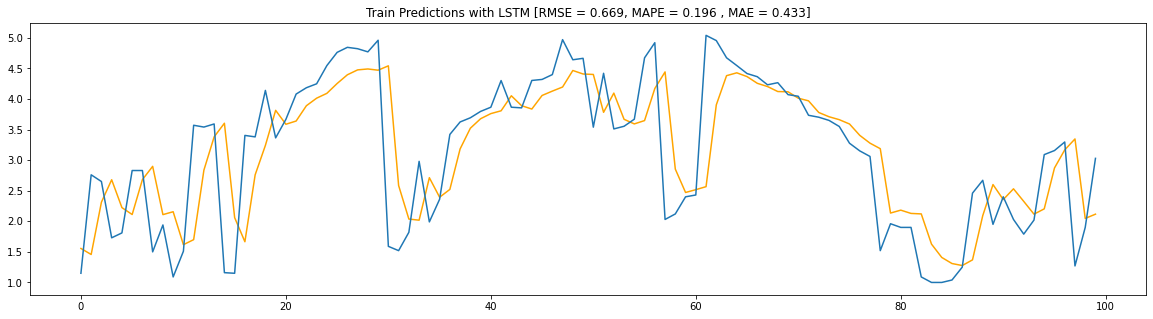

In [35]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(train_results['Train Predictions'], train_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(train_results['Train Predictions'][0:100], color='orange')
plt.plot(train_results['Actuals'][0:100])
plt.title("Train Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

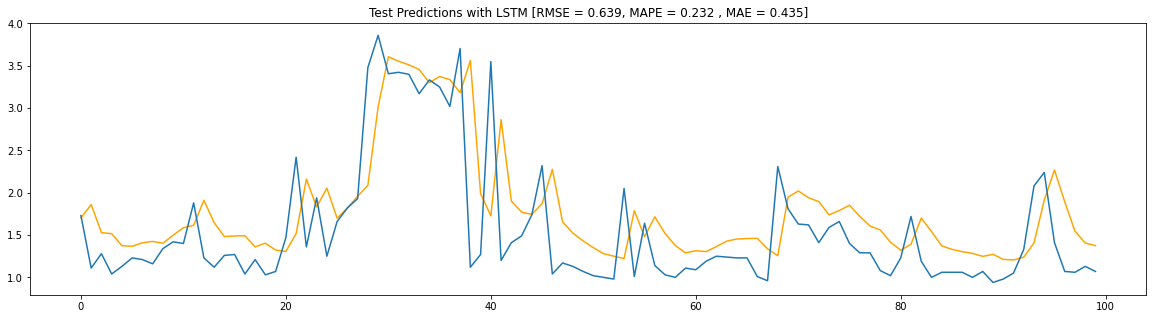

In [36]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(test_results['test Predictions'], test_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(test_results['test Predictions'][0:100], color='orange')
plt.plot(test_results['Actuals'][0:100])
plt.title("Test Predictions with LSTM [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

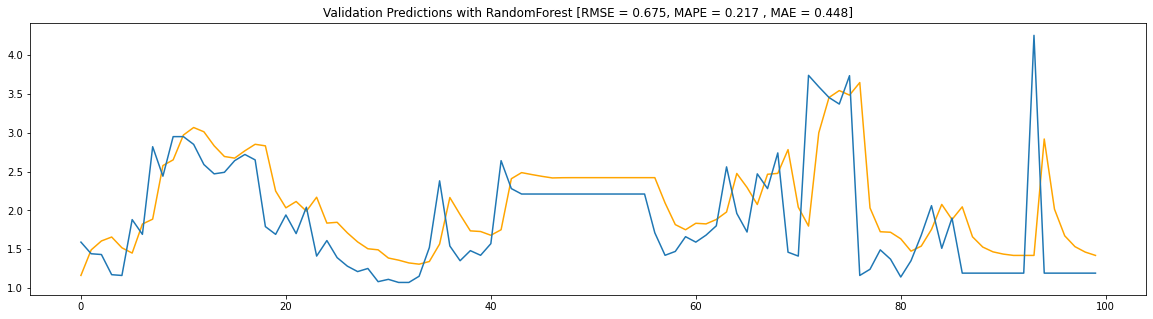

In [37]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(val_results['val Predictions'], val_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(val_results['val Predictions'][0:100], color='orange')
plt.plot(val_results['Actuals'][0:100])
plt.title("Validation Predictions with RandomForest [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
plt.show()

In [38]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mae', 'mean_squared_error', 'root_mean_squared_error', 'val_loss', 'val_accuracy', 'val_mae', 'val_mean_squared_error', 'val_root_mean_squared_error', '_timestamp', '_runtime'])


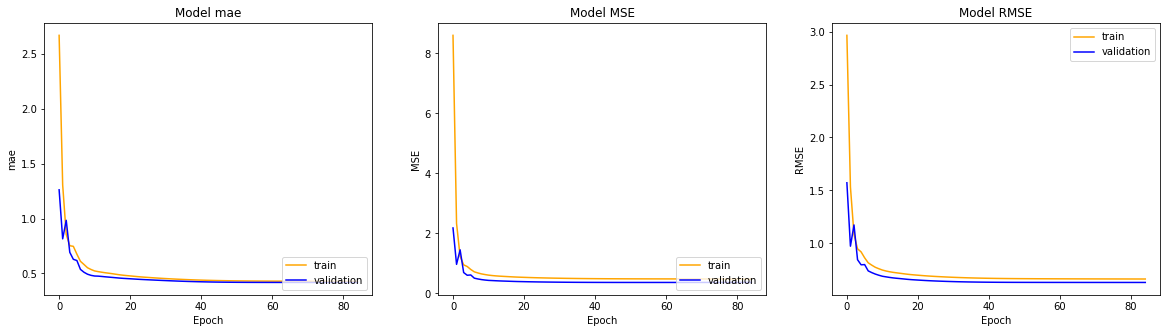

In [39]:
def plot_performance(model_history):
    # modle performance visualization
    # subplot
    fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

    # mae
    ax1.plot(model_history.history['mae'], color='orange')
    ax1.plot(model_history.history['val_mae'], color='blue')
    ax1.set_title('Model mae')
    ax1.set_ylabel('mae')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    # mean_squared_error
    ax2.plot(model_history.history['mean_squared_error'], color='orange')
    ax2.plot(model_history.history['val_mean_squared_error'], color='blue')
    ax2.set_title('Model MSE')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='lower right')

    # "root_mean_squared_error"
    ax3.plot(model_history.history['root_mean_squared_error'], color='orange')
    ax3.plot(model_history.history['val_root_mean_squared_error'], color='blue')
    ax3.set_title('Model RMSE')
    ax3.set_ylabel('RMSE')
    ax3.set_xlabel('Epoch')
    ax3.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
plot_performance(history)